<a href="https://colab.research.google.com/github/GulsumSayin/OSCC-Histopathology-Classification/blob/main/OSCC_DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Gerekli Kütüphanelerin İmport Edilmesi

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Drive'a Bağlanma**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Veri Setinin Alınması

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Veri klasörleri
base_dir = "/content/drive/MyDrive/final_dataset"
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

# Ayarlar
image_size = (224, 224)
batch_size = 32

# Train için augmentasyon + normalizasyon
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# Val ve test: sadece normalize
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Veri yükleyiciler
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_data = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_data = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Kontrol
print("✅ Train sınıfları:", train_data.class_indices)
print("✅ Val sınıfları:", val_data.class_indices)
print("✅ Test sınıfları:", test_data.class_indices)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
✅ Train sınıfları: {'normal': 0, 'oscc': 1}
✅ Val sınıfları: {'normal': 0, 'oscc': 1}
✅ Test sınıfları: {'normal': 0, 'oscc': 1}


#### Modelin Oluşturulması

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

def build_densenet121_model(input_shape=(224, 224, 3)):
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # Fine-tuning tüm katmanlar açık

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_densenet121_model()
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 7,216,513 (27.53 MB)

 Non-trainable params: 83,648 (326.75 KB)

**Modelin Derlenmesi**

In [ ]:
from tensorflow.keras.optimizers import Adamax,Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(label_smoothing=0.05),
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ReduceLROnPlateau: val_loss durursa lr'i azalt
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

# Erken durdurma
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

callbacks = [early_stop,reduce_lr]

#### Model Eğitimi

In [ ]:
history_1 = model.fit(
    train_data,
    epochs=40,
    validation_data=val_data,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 1596s 19s/step - accuracy: 0.6546 - loss: 0.6735 - precision: 0.6453 - recall: 0.6173 - val_accuracy: 0.8500 - val_loss: 0.3843 - val_precision: 0.8070 - val_recall: 0.9200 - learning_rate: 1.0000e-04
Epoch 2/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.8763 - loss: 0.3475 - precision: 0.8812 - recall: 0.8660 - val_accuracy: 0.9133 - val_loss: 0.2958 - val_precision: 0.9189 - val_recall: 0.9067 - learning_rate: 1.0000e-04
Epoch 3/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9211 - loss: 0.2677 - precision: 0.9245 - recall: 0.9178 - val_accuracy: 0.9367 - val_loss: 0.2511 - val_precision: 0.9580 - val_recall: 0.9133 - learning_rate: 1.0000e-04
Epoch 4/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9270 - loss: 0.2585 - precision: 0.9372 - recall: 0.9147 - val_accuracy: 0.9633 - val_loss: 0.2232 - val_precision: 0.9860 - val_recall: 0.9400 - learning_rate: 1.0000e-04
Epoch 5/40
75/75 ━━━━━━━━━━━━━━━━━━━━ 150s 2s/step

#### Eğitimin Görselleştirilmesi

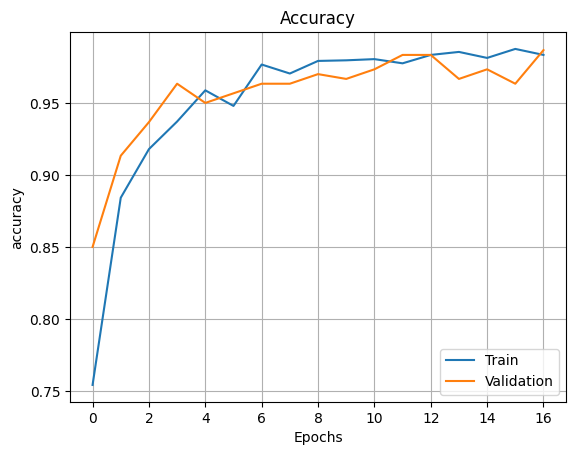

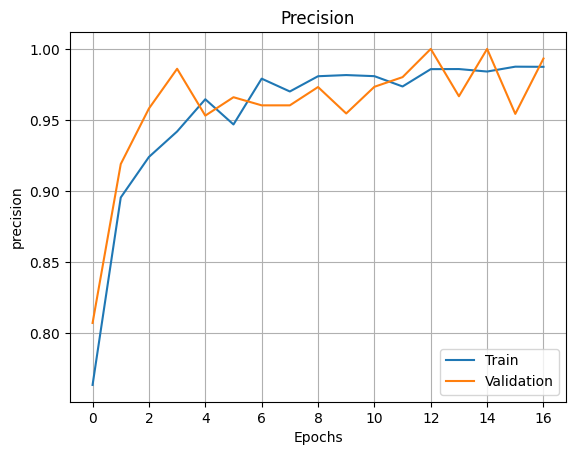

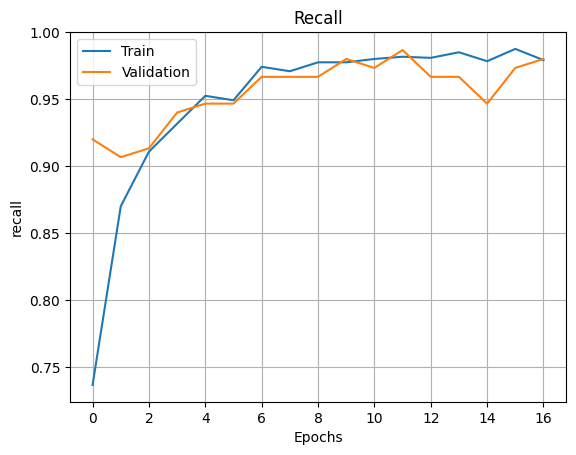

In [ ]:
# Eğitim metriklerini görselleştir
def plot_training(history):
    metrics = ['accuracy', 'precision', 'recall']
    for metric in metrics:
        plt.figure()
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history['val_' + metric], label='Validation')
        plt.title(metric.title())
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

plot_training(history_1)

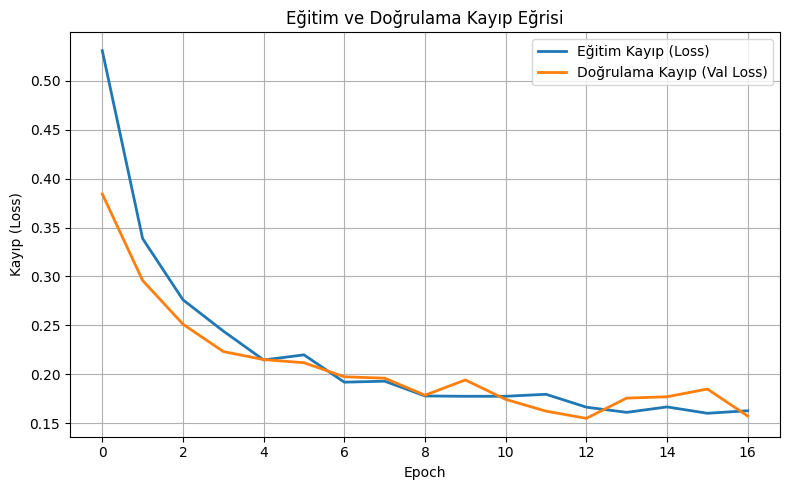

In [ ]:
def plot_loss_curves(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'], label='Eğitim Kayıp (Loss)', linewidth=2)
    plt.plot(history.history['val_loss'], label='Doğrulama Kayıp (Val Loss)', linewidth=2)
    plt.title('Eğitim ve Doğrulama Kayıp Eğrisi')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp (Loss)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(history_1)

### Modelin Test Edilmesi

In [ ]:
from sklearn.metrics import roc_curve

y_pred_prob = model.predict(test_data)
y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

10/10 ━━━━━━━━━━━━━━━━━━━━ 237s 24s/step
Optimal threshold: 0.2755832


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[145   5]
 [  8 142]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       150
           1       0.97      0.95      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



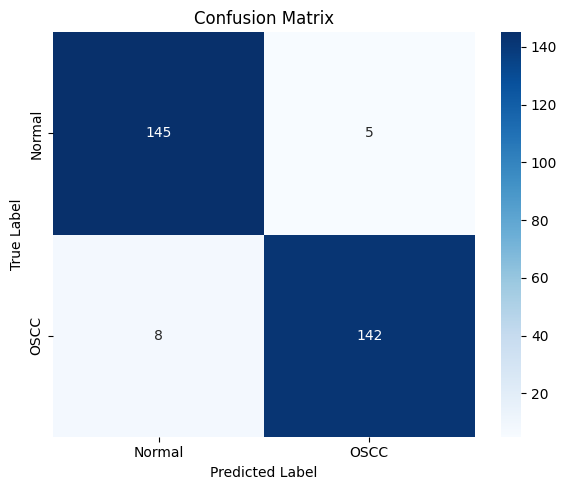

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'OSCC'],
            yticklabels=['Normal', 'OSCC'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

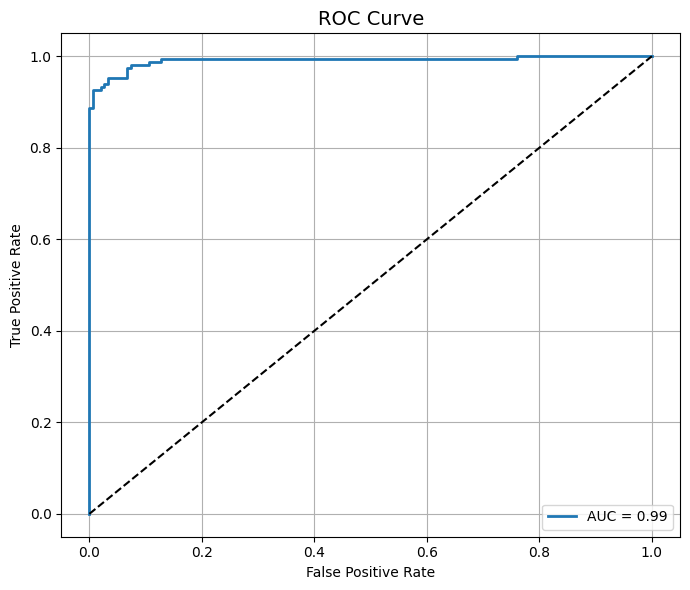

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", linewidth=2)
plt.plot([0,1], [0,1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

In [ ]:
kappa = cohen_kappa_score(y_true, y_pred)
print("Cohen's Kappa Skoru:", kappa)

Cohen's Kappa Skoru: 0.9133333333333333


**Modelin Kaydedilmesi**

In [ ]:
model.save('/content/drive/MyDrive/agiz_kanseri_densenet.keras')

#### Grad CAM

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Gradients
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Weighted feature maps
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def display_gradcam(img_path, model, last_conv_layer_name='conv5_block16_concat', alpha=0.5):
    # 1. Görseli yükle
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # 2. Heatmap üret
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    # 3. Görselleştir
    img_cv = cv2.imread(img_path)
    img_cv = cv2.resize(img_cv, (224, 224))
    heatmap_resized = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_cv, 1 - alpha, heatmap_colored, alpha, 0)

    # 4. Göster
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(img_cv[..., ::-1])
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Superimposed")
    plt.imshow(superimposed_img[..., ::-1])
    plt.axis("off")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


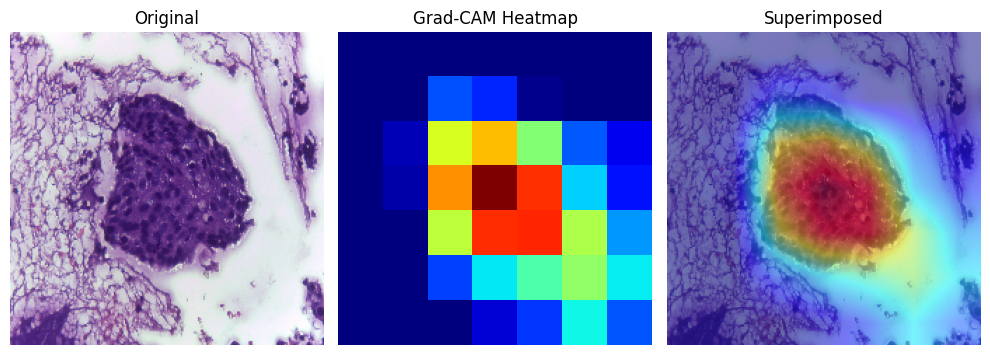

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg"
display_gradcam(img_path, model)

#### Integrated Gradients

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


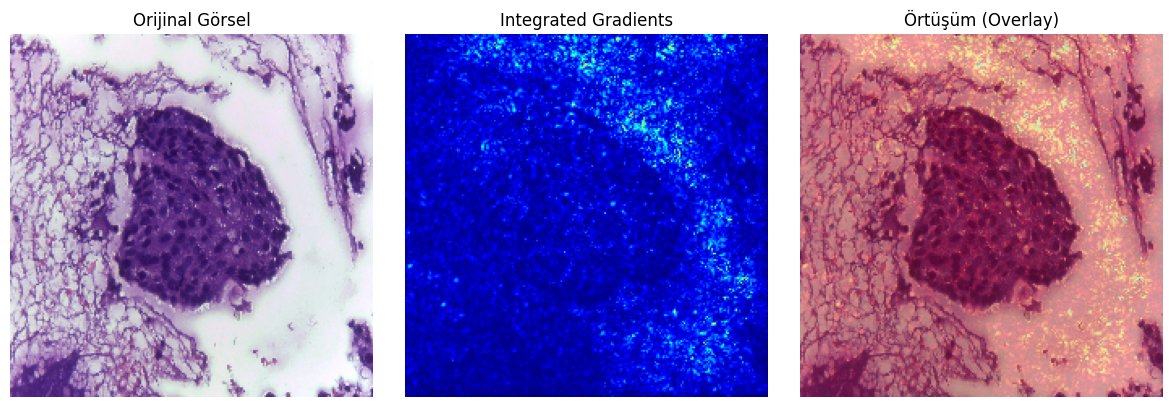

In [ ]:
# 🔧 Gerekli kütüphaneler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Görseli yükle ve ön işle
img_path = "/content/drive/MyDrive/final_dataset/train/oscc/OSCC_400x_495.jpg" # test görselin
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Hedef sınıfı al (tahmin edilen sınıf)
preds = model.predict(img_batch)
target_class_idx = int(np.round(preds[0][0]))  # sigmoid olduğu için 0 veya 1

# Integrated Gradients fonksiyonları
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        output = preds[:, 0]  # sigmoid tek çıktı
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, image, target_class_idx, m_steps=50):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()
    delta = (image - baseline).numpy()[0]
    integrated_grads = delta * avg_grads
    return integrated_grads

# Sıfır referans (siyah görüntü)
baseline = tf.zeros(shape=(1, 224, 224, 3))

# Integrated Gradients hesapla
ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch), target_class_idx)

# Normalize etme
attribution = np.mean(np.abs(ig), axis=-1)
attribution -= attribution.min()
attribution /= attribution.max()

# Görselleştirme
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title("Orijinal Görsel")
axs[0].axis("off")

axs[1].imshow(attribution, cmap='jet')
axs[1].set_title("Integrated Gradients")
axs[1].axis("off")

heatmap = cv2.applyColorMap(np.uint8(255 * attribution), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.array(img).astype(np.uint8), 0.6, heatmap, 0.4, 0)
axs[2].imshow(overlay)
axs[2].set_title("Örtüşüm (Overlay)")
axs[2].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print("Model çıktısı (olasılık):", preds[0][0])

Model çıktısı (olasılık): 0.9209858


In [ ]:
!pip install tf_explain

**Modelin Yüklenmesi**

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/agiz_kanseri_densenet.keras")

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model("/content/drive/MyDrive/agiz_kanseri_densenet.keras")

# Derleme gerekiyorsa:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Değerlendirme (örnek olarak test_data ile)
results = model.evaluate(test_data)
print(f"\nTest Sonuçları:\n  Loss: {results[0]:.4f}\n  Accuracy: {results[1]:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - accuracy: 0.9790 - loss: 0.0765

Test Sonuçları:
  Loss: 0.1241
  Accuracy: 0.9567


In [ ]:
import numpy as np

X_test = []
y_true = []

# test_data: DirectoryIterator
for i in range(len(test_data)):
    x, y = test_data[i]
    X_test.append(x)
    y_true.append(y)

X_test = np.vstack(X_test)
y_true = np.hstack(y_true)

y_pred_prob = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step


In [ ]:
from sklearn.metrics import roc_curve

y_true = test_data.classes

# ROC eğrisini hesapla
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold:", optimal_threshold)

# Yeni tahminler
y_pred = (y_pred_prob > optimal_threshold).astype(int)

Optimal threshold: 0.2755832


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

[[145   5]
 [  8 142]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       150
           1       0.97      0.95      0.96       150

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


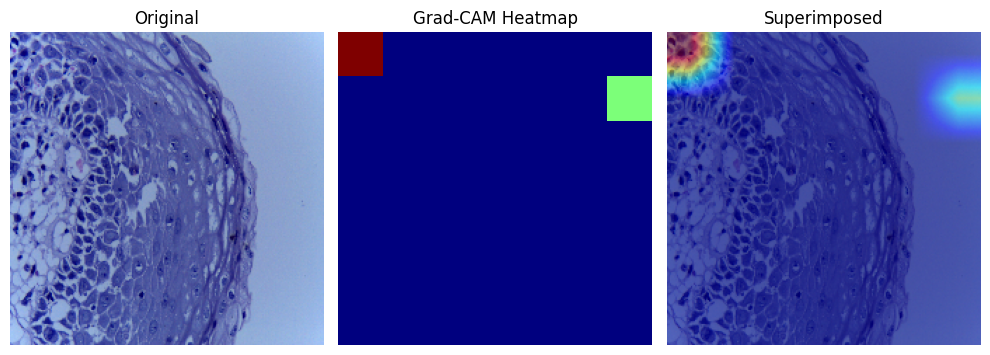

In [ ]:
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg"
display_gradcam(img_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


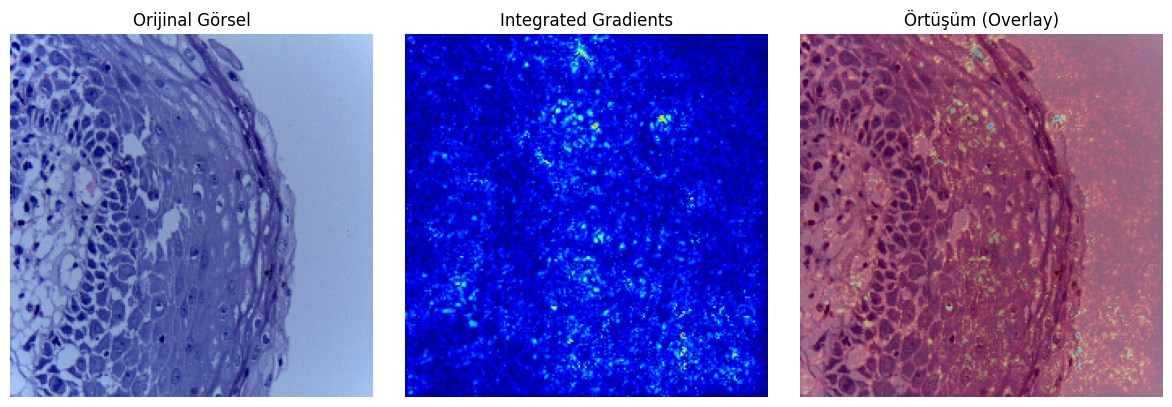

In [ ]:
# Gerekli kütüphaneler
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model


# Görseli yükleme ve ön işleme
img_path = "/content/drive/MyDrive/final_dataset/train/normal/Normal_400x_193.jpg" # test görselin
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0) / 255.0  # normalize

# Hedef sınıfı al (tahmin edilen sınıf)
preds = model.predict(img_batch)
target_class_idx = int(np.round(preds[0][0]))  # sigmoid olduğu için 0 veya 1

# Integrated Gradients fonksiyonları
@tf.function
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    delta = image - baseline
    images = baseline + alphas_x * delta
    return images

@tf.function
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        output = preds[:, 0]  # sigmoid tek çıktı
    grads = tape.gradient(output, images)
    return grads

def integrated_gradients(baseline, image, target_class_idx, m_steps=50):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    interpolated = interpolate_images(baseline, image, alphas)
    grads = compute_gradients(interpolated, target_class_idx)
    avg_grads = tf.reduce_mean(grads, axis=0).numpy()
    delta = (image - baseline).numpy()[0]
    integrated_grads = delta * avg_grads
    return integrated_grads

# Sıfır referans (siyah görüntü)
baseline = tf.zeros(shape=(1, 224, 224, 3))

# Integrated Gradients hesaplama
ig = integrated_gradients(baseline, tf.convert_to_tensor(img_batch), target_class_idx)

# Normalize etme
attribution = np.mean(np.abs(ig), axis=-1)
attribution -= attribution.min()
attribution /= attribution.max()

# Görselleştirme
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(np.array(img).astype(np.uint8))
axs[0].set_title("Orijinal Görsel")
axs[0].axis("off")

axs[1].imshow(attribution, cmap='jet')
axs[1].set_title("Integrated Gradients")
axs[1].axis("off")

heatmap = cv2.applyColorMap(np.uint8(255 * attribution), cv2.COLORMAP_JET)
overlay = cv2.addWeighted(np.array(img).astype(np.uint8), 0.6, heatmap, 0.4, 0)
axs[2].imshow(overlay)
axs[2].set_title("Örtüşüm (Overlay)")
axs[2].axis("off")

plt.tight_layout()
plt.show()